In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings 

warnings.filterwarnings('ignore')


## Functions

In [2]:
def last_x_weeks(data, week):
    return data[data['last_x_weeks'] == week]

def count_non_zero(column):
    return column[column > 0].count()

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def get_activity_summary(data, column):
    return data.groupby('last_x_weeks').agg({
        column : ['mean', 'std', 'median', 'max']
    }).reset_index()



#### 1. Load and Inspect Dataset

In [3]:
# Load dataset
data = pd.read_csv('../data/data_analyst.csv')

# Print the first few rows of the dataset
data.head()

,USER_ID,LAST_X_WEEKS,POSTS_CREATED,REPLIES_RECEIVED,THANKYOUS_RECEIVED,EVENTS_CREATED,EVENT_PARTICIPANTS,ITEMS_GIFTED,PLACES_RECOMMENDED
0,1,4,1.0,0.0,6.0,NaN,NaN,NaN,NaN
1,1,6,1.0,0.0,6.0,NaN,NaN,NaN,NaN
2,1,8,1.0,0.0,6.0,NaN,NaN,NaN,NaN
3,1,12,2.0,0.0,6.0,NaN,NaN,NaN,NaN
4,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Convert column names to lowercase
data.columns = data.columns.str.lower()

In [5]:
# 80,000 rows in total and activity columns are of type float
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             80000 non-null  int64  
 1   last_x_weeks        80000 non-null  int64  
 2   posts_created       36101 non-null  float64
 3   replies_received    36101 non-null  float64
 4   thankyous_received  36101 non-null  float64
 5   events_created      5304 non-null   float64
 6   event_participants  5304 non-null   float64
 7   items_gifted        13224 non-null  float64
 8   places_recommended  7127 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 5.5 MB


In [6]:
# print basic summary statistics of the dataset - outliers across all columns except 'last_x_weeks' and 'user_id
data.describe()

,user_id,last_x_weeks,posts_created,replies_received,thankyous_received,events_created,event_participants,items_gifted,places_recommended
count,80000.000000,80000.000000,36101.000000,36101.000000,36101.000000,5304.000000,5304.000000,13224.000000,7127.000000
mean,10000.500000,7.500000,1.560455,2.804438,1.729869,1.747172,2.990196,1.832350,2.558861
std,5773.538769,2.958058,5.300670,5.023577,5.613324,2.073147,3.954328,2.153866,4.221170
min,1.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,5000.750000,5.500000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
50%,10000.500000,7.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000
75%,15000.250000,9.000000,2.000000,4.000000,1.000000,2.000000,3.000000,2.000000,2.000000
max,20000.000000,12.000000,698.000000,139.000000,194.000000,36.000000,58.000000,58.000000,155.000000


#### 2. Check Missing Values


In [7]:
# 93% of values missing for events_created/events_participated
missing_values = round(data.isna().sum() / len(data) * 100,2)
missing_values

user_id                0.00
last_x_weeks           0.00
posts_created         54.87
replies_received      54.87
thankyous_received    54.87
events_created        93.37
event_participants    93.37
items_gifted          83.47
places_recommended    91.09
dtype: float64

In [8]:
# missing values by weeks - highest percentage of missing values occur in last 4 weeks across all columns
missing_by_week = data.groupby('last_x_weeks').apply(lambda x: x.isna().sum() / 20000 * 100).drop(columns=['user_id', 'last_x_weeks'])
missing_by_week

,posts_created,replies_received,thankyous_received,events_created,event_participants,items_gifted,places_recommended
last_x_weeks,,,,,,,
4,73.980,73.980,73.980,95.755,95.755,90.245,94.775
6,62.485,62.485,62.485,94.410,94.410,86.070,92.570
8,51.755,51.755,51.755,93.120,93.120,82.040,90.635
12,31.275,31.275,31.275,90.195,90.195,75.525,86.385


In [9]:
# Fill missing values with 0 - Assumed that 0 is equivalent to no activity 
data = data.fillna(0)


In [10]:
# Split data into different weeks
last_4_weeks = last_x_weeks(data, 4)
last_6_weeks = last_x_weeks(data, 6)
last_8_weeks = last_x_weeks(data, 8)
last_12_weeks = last_x_weeks(data, 12)

### User Engagement Analysis

##### a. No. of Active Users Over Last 4, 6, 8 and 12 Weeks

In [11]:
# Calculate the number of non-zero values in each activity column for the last 12 weeks
activity_columns = ['posts_created', 'replies_received', 'events_created', 'event_participants', 'items_gifted', 'places_recommended', 'thankyous_received']
w4_activity_counts = last_4_weeks[activity_columns].apply(count_non_zero)
w6_activity_counts = last_6_weeks[activity_columns].apply(count_non_zero)
w8_activity_counts = last_8_weeks[activity_columns].apply(count_non_zero)
w12_activity_counts = last_12_weeks[activity_columns].apply(count_non_zero)

# combine the counts into a single DataFrame for better visualization
last_4_week_activity_count = pd.DataFrame(w4_activity_counts, columns=['w4_count']).reset_index().rename(columns={'index': 'activity'}).sort_values(by='w4_count', ascending=False)
last_6_week_activity_count = pd.DataFrame(w6_activity_counts, columns=['w6_count']).reset_index().rename(columns={'index': 'activity'}).sort_values(by='w6_count', ascending=False)
last_8_week_activity_count = pd.DataFrame(w8_activity_counts, columns=['w8_count']).reset_index().rename(columns={'index': 'activity'}).sort_values(by='w8_count', ascending=False)
last_12_week_activity_count = pd.DataFrame(w12_activity_counts, columns=['w12_count']).reset_index().rename(columns={'index': 'activity'}).sort_values(by='w12_count', ascending=False)

# Merge the counts into a single DataFrame
activity_counts = pd.merge(last_4_week_activity_count, last_6_week_activity_count, on='activity')
activity_counts = pd.merge(activity_counts, last_8_week_activity_count, on='activity')
activity_counts = pd.merge(activity_counts, last_12_week_activity_count, on='activity')

# activity_counts.set_index('activity', inplace=True)
activity_counts


,activity,w4_count,w6_count,w8_count,w12_count
0,posts_created,5204,7503,9649,13745
1,replies_received,3172,4654,6035,8821
2,thankyous_received,2128,3211,4279,6364
3,items_gifted,1951,2786,3592,4895
4,places_recommended,1045,1486,1873,2723
5,events_created,849,1118,1376,1961
6,event_participants,825,1076,1328,1901


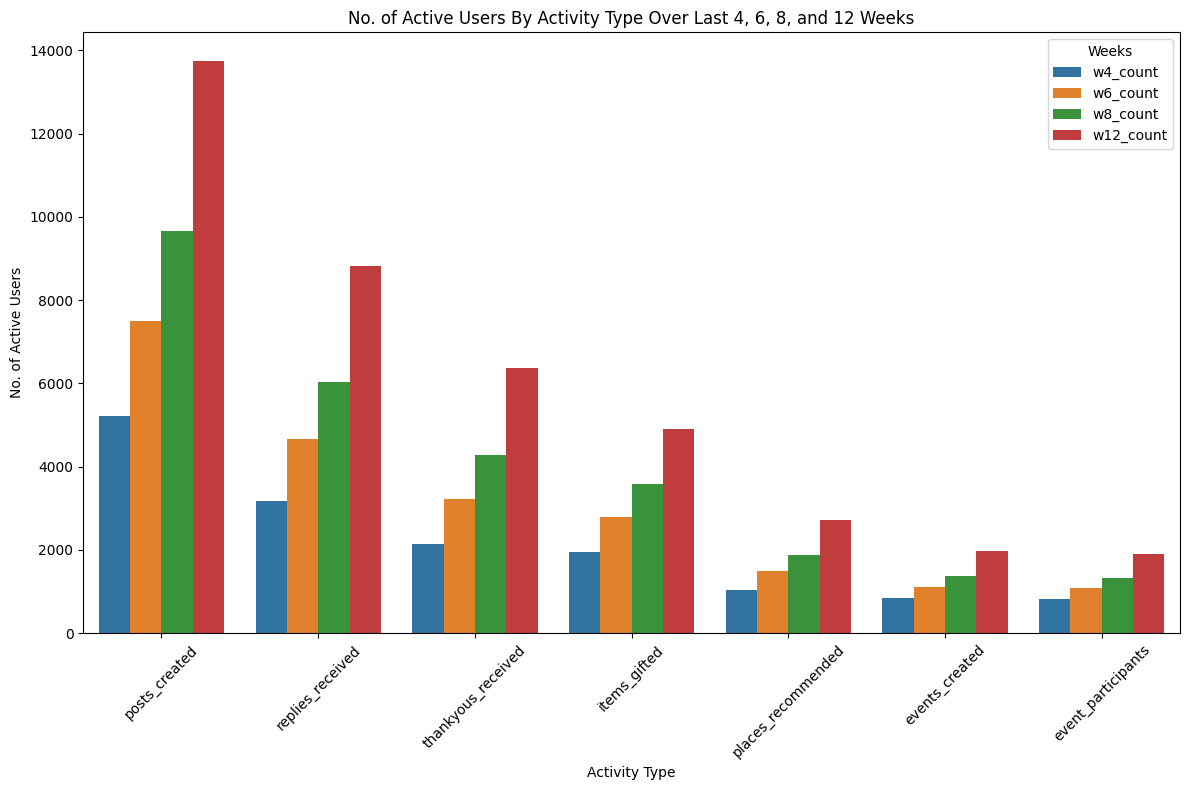

In [12]:
# Plot the activity counts for the last 4, 6, 8, and 12 weeks - highest engagement occurs in last 12 weeks - longest timeframe
plt.figure(figsize=(12, 8))
sns.barplot(data=activity_counts.melt(id_vars='activity'), x='activity', y='value', hue='variable')
plt.title('No. of Active Users By Activity Type Over Last 4, 6, 8, and 12 Weeks')
plt.xlabel('Activity Type')
plt.ylabel('No. of Active Users')
plt.xticks(rotation=45)
plt.legend(title='Weeks', loc='upper right')
plt.tight_layout()


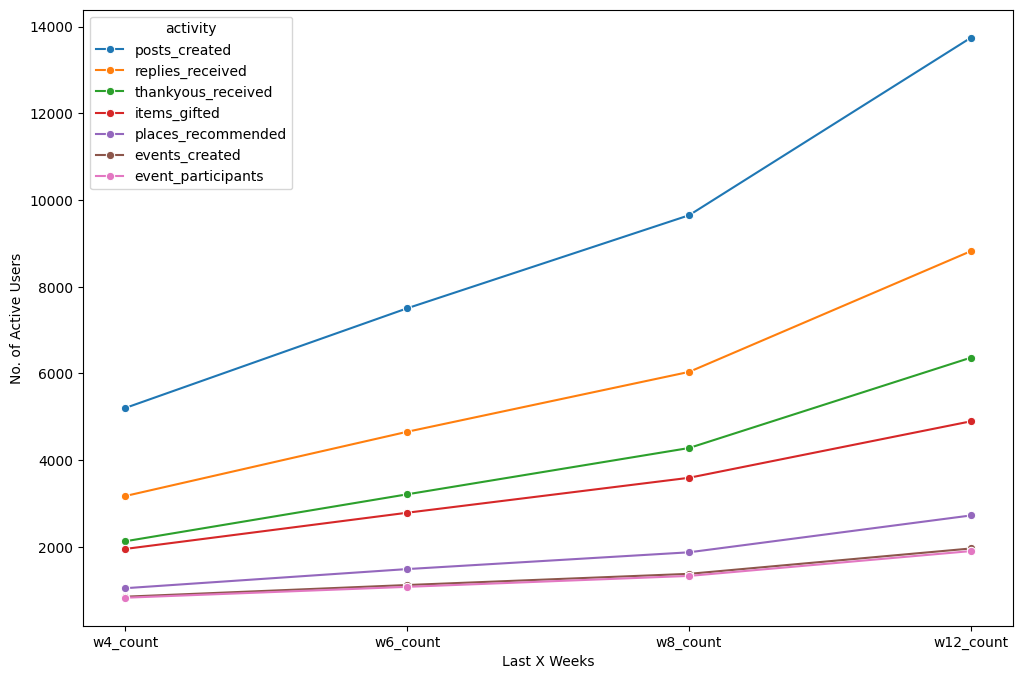

In [13]:
plt.figure(figsize=(12, 8))
sns.lineplot(data=activity_counts.melt(id_vars='activity'), hue='activity', y='value', x='variable', marker='o')
plt.xlabel('Last X Weeks')
plt.ylabel('No. of Active Users')
plt.show()

##### b. Statistical Analysis and Distribution of Activities

In [14]:
# Calculate activity on a per week basis
for col in activity_columns:
    data[f'{col}_per_week'] = data[col] / data['last_x_weeks']

# Keep per week columns but drop total columns
data_per_week = data.drop(columns=activity_columns)

##### i. Posts Created & Replies Received Per Week

In [15]:
posts_created_pw_summ = get_activity_summary(data_per_week, 'posts_created_per_week')
posts_created_pw_summ['mean_pct_change'] = round(posts_created_pw_summ['posts_created_per_week']['mean'].pct_change() * 100,2)
posts_created_pw_summ


last_x_weeks posts_created_per_week                                 \
                                 mean       std    median        max   
0            4               0.089612  0.546357  0.000000  72.500000   
1            6               0.091858  0.470035  0.000000  62.166667   
2            8               0.093119  0.451860  0.000000  60.250000   
3           12               0.096846  0.432840  0.083333  58.166667   

  mean_pct_change  
                   
0             NaN  
1            2.51  
2            1.37  
3            4.00

In [16]:
replies_created_pw_summ = get_activity_summary(data_per_week, 'replies_received_per_week')
replies_created_pw_summ['mean_pct_change'] = round(replies_created_pw_summ['replies_received_per_week']['mean'].pct_change() * 100,2)
replies_created_pw_summ

last_x_weeks replies_received_per_week                              \
                                    mean       std median        max   
0            4                  0.155000  0.558802    0.0  14.000000   
1            6                  0.164333  0.498867    0.0  11.833333   
2            8                  0.166600  0.466636    0.0  13.750000   
3           12                  0.176946  0.410096    0.0  11.583333   

  mean_pct_change  
                   
0             NaN  
1            6.02  
2            1.38  
3            6.21

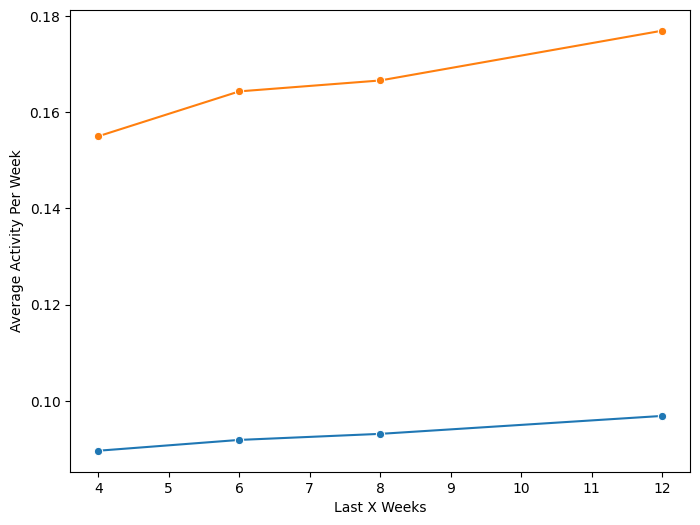

In [17]:
plt.figure(figsize=(8,6))
sns.lineplot(y=posts_created_pw_summ['posts_created_per_week']['mean'], x=posts_created_pw_summ['last_x_weeks'], marker='o', linestyle='-')
sns.lineplot(y=replies_created_pw_summ['replies_received_per_week']['mean'], x=replies_created_pw_summ['last_x_weeks'], marker='o')
plt.ylabel('Average Activity Per Week')
plt.xlabel('Last X Weeks')
plt.show()

In [18]:
post_replies_per_week = data_per_week[['user_id', 'last_x_weeks', 'posts_created_per_week', 'replies_received_per_week']]

# Calculate no. of replies received per post 
post_replies_per_week.loc[:, 'post_replies_ratio'] = post_replies_per_week.loc[:, 'replies_received_per_week'] / post_replies_per_week.loc[:,'posts_created_per_week']

# Fill any missing values with 0 
post_replies_per_week['post_replies_ratio'].fillna(0.0, inplace=True)

# Get Post Replies Summary
post_replies_pw_summ = get_activity_summary(post_replies_per_week, 'post_replies_ratio')
post_replies_pw_summ['mean_pct_change'] = round(post_replies_pw_summ['post_replies_ratio']['mean'].pct_change() * 100,2)
post_replies_pw_summ


last_x_weeks post_replies_ratio                        mean_pct_change
                             mean       std median   max                
0            4           0.471665  1.584921    0.0  41.0             NaN
1            6           0.706225  1.985164    0.0  43.0           49.73
2            8           0.894233  2.157098    0.0  44.0           26.62
3           12           1.294833  2.457910    0.0  44.0           44.80

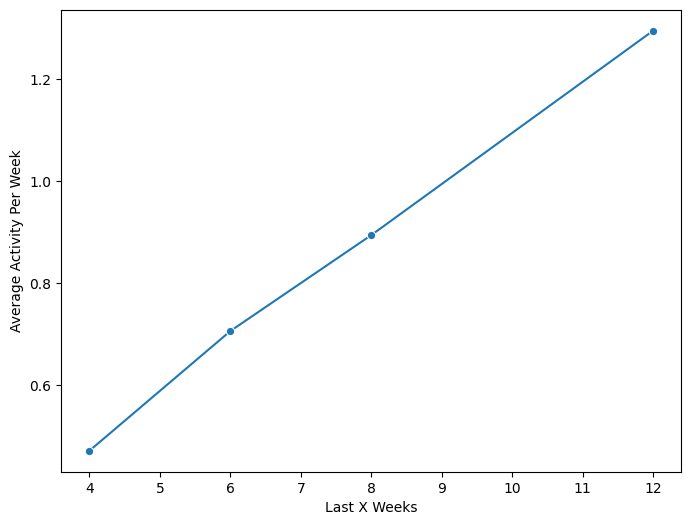

In [ ]:
plt.figure(figsize=(8,6))
sns.lineplot(y=post_replies_pw_summ['post_replies_ratio']['mean'], x=post_replies_pw_summ['last_x_weeks'], marker='o', linestyle='-')
plt.ylabel('Average Activity Per Week')
plt.xlabel('Last X Weeks')
plt.show()

In [ ]:
# # Pivot table: rows = user_id, columns = last_x_weeks
# pivot_per_week = data_per_week.pivot(index='user_id', columns='last_x_weeks', values='posts_created_per_week')

# # Calculate row-wise standard deviation and variance (drift)
# pivot_per_week['std_drift'] = pivot_per_week.std(axis=1)
# pivot_per_week['range_drift'] = pivot_per_week.max(axis=1) - pivot_per_week.min(axis=1)

# # Overall stability metric
# mean_std_drift = pivot_per_week['std_drift'].mean()
# mean_range_drift = pivot_per_week['range_drift'].mean()

# print(f"Mean standard deviation across timeframes: {mean_std_drift:.4f}")
# print(f"Mean range (max - min): {mean_range_drift:.4f}")

Mean standard deviation across timeframes: 0.0514
Mean range (max - min): 0.1334


##### ii. Events Created and Event Participants Per Week

In [ ]:
events_created_pw_summ = get_activity_summary(data_per_week, 'events_created_per_week')
event_participants_pw_summ = get_activity_summary(data_per_week, 'event_participants_per_week')

plt.figure(figsize=(8,6))
sns.lineplot(y=events_created_pw_summ['events_created_per_week']['mean'], x=events_created_pw_summ['last_x_weeks'], marker='o', linestyle='-')
sns.lineplot(y=event_participants_pw_summ['event_participants_per_week']['mean'], x=event_participants_pw_summ['last_x_weeks'], marker='o', linestyle='-')
plt.ylabel('Average Activity Per Week')
plt.xlabel('Last X Weeks')
plt.show()


In [ ]:
# summary = data_per_week.groupby('last_x_weeks').agg({
#     'posts_created_per_week': ['mean', 'std', 'median'],
#     'replies_received_per_week': ['mean', 'std', 'median'],
#     'thankyous_received_per_week': ['mean', 'std', 'median'],
#     'events_created_per_week': ['mean', 'std','median'], 
#     'event_participants_per_week': ['mean', 'std', 'median'], 
#     'places_recommended_per_week' : ['mean', 'std', 'median'], 
#     'items_gifted_per_week': ['mean', 'std', 'median']
# }).reset_index()

# summary

#### c. Distributions of Activities

In [ ]:
posts_replies_per_week = data_per_week[['user_id', 'last_x_weeks', 'posts_created_per_week', 'replies_received_per_week']]
w4_posts_replies_per_week = posts_replies_per_week[posts_replies_per_week['last_x_weeks'] == 4]
w6_posts_replies_per_week = posts_replies_per_week[posts_replies_per_week['last_x_weeks'] == 6]
w8_posts_replies_per_week = posts_replies_per_week[posts_replies_per_week['last_x_weeks'] == 8]
w12_posts_replies_per_week = posts_replies_per_week[posts_replies_per_week['last_x_weeks'] == 12]

In [ ]:
print('User ID with most posts (last 4 weeks): ', w4_posts_replies_per_week[w4_posts_replies_per_week['posts_created_per_week'] == w4_posts_replies_per_week['posts_created_per_week'].max()]['user_id'].unique())
print('User ID with most posts (last 6 weeks): ', w6_posts_replies_per_week[w6_posts_replies_per_week['posts_created_per_week'] == w6_posts_replies_per_week['posts_created_per_week'].max()]['user_id'].unique())
print('User ID with most posts (last 8 weeks): ', w8_posts_replies_per_week[w8_posts_replies_per_week['posts_created_per_week'] == w8_posts_replies_per_week['posts_created_per_week'].max()]['user_id'].unique())
print('User ID with most posts (last 12 weeks): ', w12_posts_replies_per_week[w12_posts_replies_per_week['posts_created_per_week'] == w12_posts_replies_per_week['posts_created_per_week'].max()]['user_id'].unique())

w4_posts_replies_per_week = w4_posts_replies_per_week[w4_posts_replies_per_week['user_id'] != 17211]
w6_posts_replies_per_week = w6_posts_replies_per_week[w6_posts_replies_per_week['user_id'] != 17211]
w8_posts_replies_per_week = w8_posts_replies_per_week[w8_posts_replies_per_week['user_id'] != 17211]
w12_posts_replies_per_week = w12_posts_replies_per_week[w12_posts_replies_per_week['user_id'] != 17211]

In [ ]:
# plt.figure(figsize=(12,8))
# sns.histplot(w4_posts_replies_per_week['posts_created_per_week'], bins=50, color='blue', kde=True)
# sns.histplot(w6_posts_replies_per_week['posts_created_per_week'], bins=50, color='orange', kde=True)

# sns.boxplot(x=w6_posts_replies_per_week['posts_created_per_week'])
# sns.boxplot(x=w8_posts_replies_per_week['posts_created_per_week'])

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(summary['last_x_weeks'], summary[('posts_created_per_week', 'mean')], marker='o', label='Posts Created')
plt.plot(summary['last_x_weeks'], summary[('replies_received_per_week', 'mean')], marker='o', label='Replies Received')
plt.plot(summary['last_x_weeks'], summary[('events_created_per_week', 'mean')], marker='o', label='Events Created')
plt.plot(summary['last_x_weeks'], summary[('event_participants_per_week', 'mean')], marker='o', label='Event Participants')
plt.title('Average Engagement per Week vs Time Window')
plt.xlabel('Time Window (weeks)')
plt.ylabel('Mean per Week')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
posts_summary = data_per_week.groupby('last_x_weeks')['posts_created_per_week'].agg(
    p25=lambda x: x.quantile(0.25),
    p50='median',
    p75=lambda x: x.quantile(0.75),
    max='max'
).reset_index()

posts_summary

In [ ]:
replies_summary = data_per_week.groupby('last_x_weeks')['replies_received_per_week'].agg(
    p25=lambda x: x.quantile(0.25),
    p50='median',
    p75=lambda x: x.quantile(0.75),
    max='max'
).reset_index()
replies_summary

In [ ]:
data_per_week.groupby('last_x_weeks').agg({
    'posts_created_per_week' : [q25, 'median', q75, max], 
    'replies_received_per_week' : [q25, 'median', q75, max]
}).reset_index()